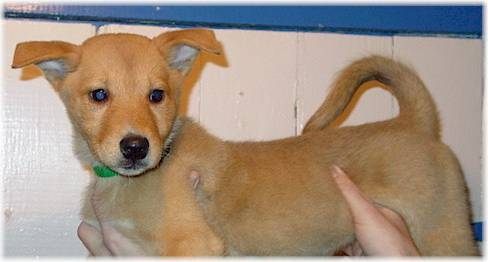

In [ ]:
# 导入模型与图像
import torch
import torch.nn as nn
from model import efficientnet_b7
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as F


model_path = "/home/jh/Blog/code/ckpts_eff/best_model.pth"
result_dict = {
    0: "cat",
    1: "dog",
    2: "other"
}

model = efficientnet_b7(num_classes=3)
model.load_state_dict(torch.load(model_path))
model.eval()


image = Image.open("/home/jh/Blog/dataset/val/dog/dog.94.jpg")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()]
)
test_image = transform(image)
test_image = test_image.unsqueeze(0)  # Add batch dimension
image

In [ ]:
# 使用单张图片进行预测
from metric import calculate_metrics_macro
from metric import calculate_metrics_micro
output = model(test_image)
target = torch.tensor([1])  # Assuming the target class is 0 for this example
_, predicted = torch.max(output, dim=1)
print(f"预测图片标签为:{predicted.item()}, 对应的类别为：{result_dict[predicted.item()]}")
precision, recall, f1_macro = calculate_metrics_macro(output, target)
precision, recall, f1_micro = calculate_metrics_micro(output, target)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_macro:.4f}")
print(f"F1 Score: {f1_micro:.4f}")

预测图片标签为:1, 对应的类别为：dog
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
F1 Score: 1.0000


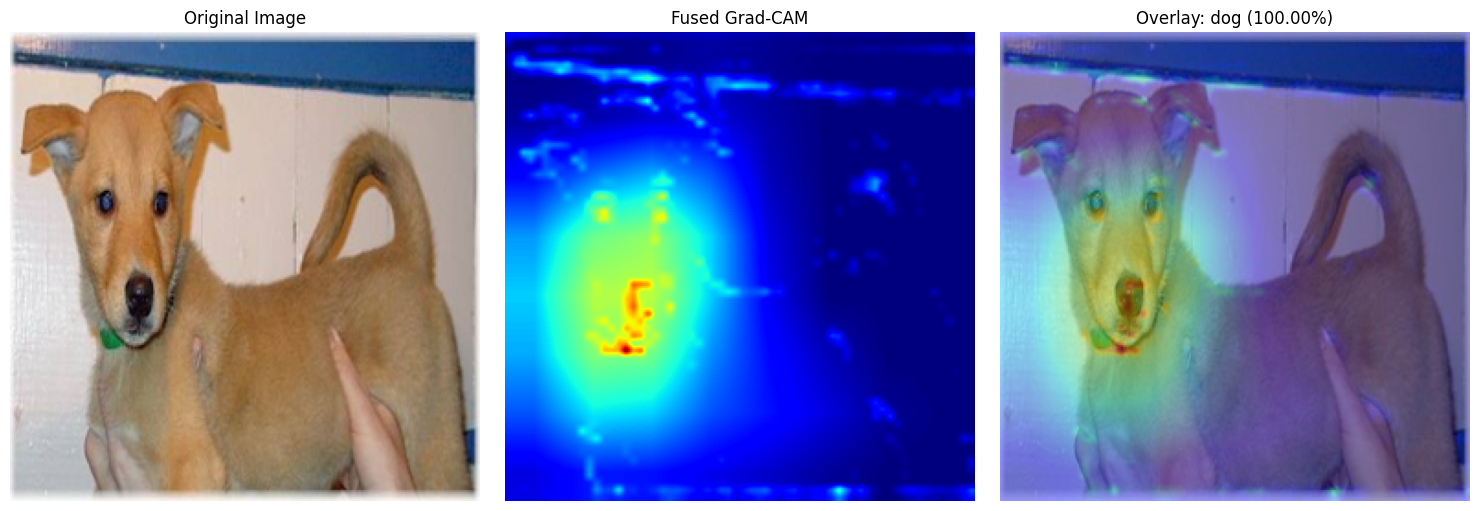

In [ ]:
# 测试热力图--模型关注的图像区域
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from model import efficientnet_b7

# ------------ 参数设定 ------------
dest_image_size = (256, 256)
label_map = {0: "cat", 1: "dog", 2: "other"}

# ------------ Grad-CAM容器 ------------
features_deep, grads_deep = None, None
features_shallow, grads_shallow = None, None

def hook_deep_fwd(m, i, o):
    global features_deep
    features_deep = o.detach()

def hook_deep_bwd(m, gi, go):
    global grads_deep
    grads_deep = go[0].detach()

def hook_shallow_fwd(m, i, o):
    global features_shallow
    features_shallow = o.detach()

def hook_shallow_bwd(m, gi, go):
    global grads_shallow
    grads_shallow = go[0].detach()

# ------------ 模型加载 ------------
model = efficientnet_b7(num_classes=3)
model.load_state_dict(torch.load("/home/jh/Blog/code/ckpts_eff/best_model.pth", map_location="cpu"))
model.eval()

# 注册钩子：浅层和深层
layer_deep = model.features.top[0]     # 深层
layer_shallow = model.features[6]      # 浅层
layer_deep.register_forward_hook(hook_deep_fwd)
layer_deep.register_full_backward_hook(hook_deep_bwd)
layer_shallow.register_forward_hook(hook_shallow_fwd)
layer_shallow.register_full_backward_hook(hook_shallow_bwd)

# ------------ 训练时同样的 transform ------------
def _norm_advprop(img):
    return img * 2.0 - 1.0

transform = transforms.Compose([
    transforms.Resize(dest_image_size, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Lambda(_norm_advprop)
])

def denormalize(t):
    return ((t + 1) / 2).clamp(0, 1)

# ------------ Grad-CAM生成函数 ------------
def compute_cam(fmap, grad, input_shape):
    weights = grad.mean(dim=(1,2))  # [C]
    cam = torch.relu((weights[:, None, None] * fmap).sum(dim=0))  # [H, W]
    cam -= cam.min()
    cam /= cam.max() + 1e-8
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=input_shape, mode='bilinear', align_corners=False)
    return cam.squeeze().cpu().numpy()

# ------------ 测试图像 ------------
img_path = "/home/jh/Blog/dataset/val/dog/dog.94.jpg"
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)

# ------------ 推理 + 获取预测类别 ------------
logits = model(input_tensor)
pred_class = logits.argmax(dim=1).item()
prob = torch.softmax(logits, dim=1)[0, pred_class].item()

# ------------ 生成CAM ------------
model.zero_grad()
logits[0, pred_class].backward(retain_graph=True)

cam_deep = compute_cam(features_deep[0], grads_deep[0], input_tensor.shape[2:])
cam_shallow = compute_cam(features_shallow[0], grads_shallow[0], input_tensor.shape[2:])

# ------------ CAM融合（加权平均） ------------
cam_fused = 0.5 * cam_deep + 0.5 * cam_shallow
cam_fused = (cam_fused - cam_fused.min()) / (cam_fused.max() + 1e-8)

# ------------ 可视化叠加 ------------
orig_img = denormalize(input_tensor[0]).permute(1, 2, 0).numpy()
heatmap = plt.get_cmap("jet")(cam_fused)[..., :3]
overlay = np.clip(0.4 * heatmap + 0.6 * orig_img, 0, 1)

# ------------ 展示结果 ------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(orig_img)
axes[0].axis("off")
axes[0].set_title("Original Image")

axes[1].imshow(cam_fused, cmap="jet")
axes[1].axis("off")
axes[1].set_title("Fused Grad-CAM")

axes[2].imshow(overlay)
axes[2].axis("off")
axes[2].set_title(f"Overlay: {label_map[pred_class]} ({prob:.2%})")

plt.tight_layout()
plt.show()


推理延迟: 146.74ms


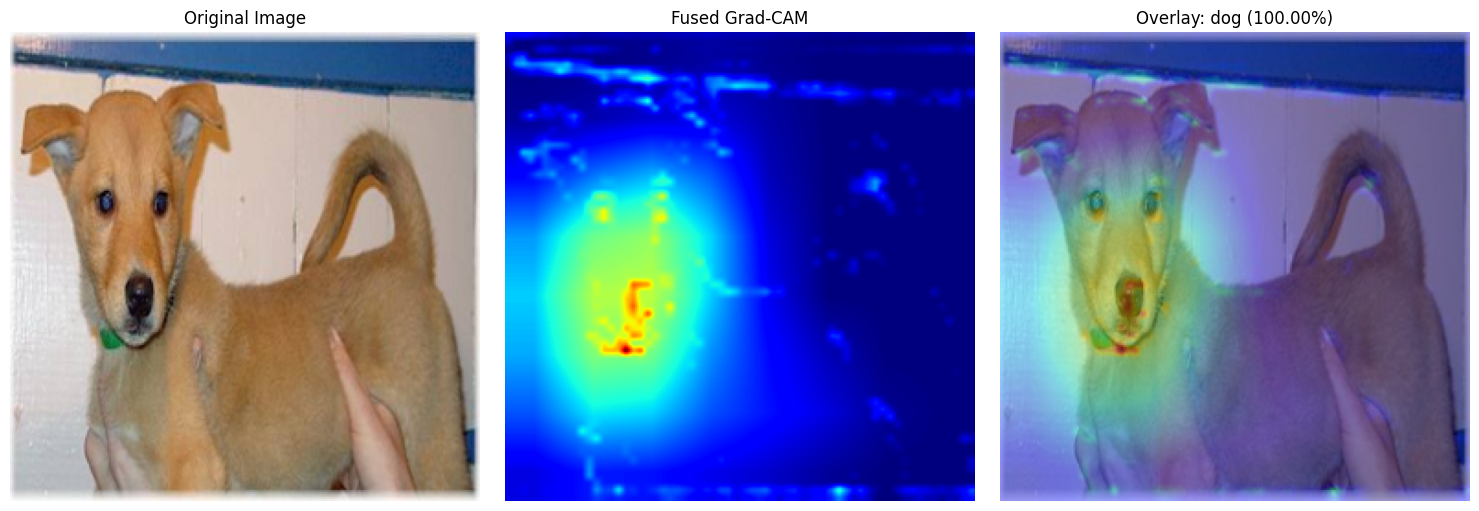

In [ ]:
# 添加模型推理时间测试
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
from model import efficientnet_b7

# ==== 新增CPU资源配置 ====
# 设置CPU亲和性（绑定到4个物理核心）
os.sched_setaffinity(0, {0, 1, 2, 3})  # 根据实际核心编号调整

# 配置PyTorch线程参数
torch.set_num_threads(4)                # 4个计算线程
torch.set_num_interop_threads(4)        # 4个并行操作线程
torch.backends.quantized.engine = 'qnnpack'  # 使用轻量级量化引擎

# ------------ 参数设定 ------------
dest_image_size = (256, 256)
label_map = {0: "cat", 1: "dog", 2: "other"}

# ------------ Grad-CAM容器 ------------
features_deep, grads_deep = None, None
features_shallow, grads_shallow = None, None

def hook_deep_fwd(m, i, o):
    global features_deep
    features_deep = o.detach()

def hook_deep_bwd(m, gi, go):
    global grads_deep
    grads_deep = go[0].detach()

def hook_shallow_fwd(m, i, o):
    global features_shallow
    features_shallow = o.detach()

def hook_shallow_bwd(m, gi, go):
    global grads_shallow
    grads_shallow = go[0].detach()

# ------------ 模型加载 ------------
model = efficientnet_b7(num_classes=3)
model.load_state_dict(torch.load("/home/jh/Blog/code/ckpts_eff/best_model.pth", map_location="cpu"))
model.eval()

# 注册钩子：浅层和深层
layer_deep = model.features.top[0]     # 深层
layer_shallow = model.features[6]      # 浅层
layer_deep.register_forward_hook(hook_deep_fwd)
layer_deep.register_full_backward_hook(hook_deep_bwd)
layer_shallow.register_forward_hook(hook_shallow_fwd)
layer_shallow.register_full_backward_hook(hook_shallow_bwd)

# ------------ 训练时同样的 transform ------------
def _norm_advprop(img):
    return img * 2.0 - 1.0

transform = transforms.Compose([
    transforms.Resize(dest_image_size, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Lambda(_norm_advprop)
])

def denormalize(t):
    return ((t + 1) / 2).clamp(0, 1)

# ------------ Grad-CAM生成函数 ------------
def compute_cam(fmap, grad, input_shape):
    weights = grad.mean(dim=(1,2))  # [C]
    cam = torch.relu((weights[:, None, None] * fmap).sum(dim=0))  # [H, W]
    cam -= cam.min()
    cam /= cam.max() + 1e-8
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=input_shape, mode='bilinear', align_corners=False)
    return cam.squeeze().cpu().numpy()


# ------------ 新增推理延迟测量 ------------
# 预热运行（3次空推理）
with torch.no_grad():
    for _ in range(3):
        _ = model(input_tensor)

# 正式测量
start_time = time.perf_counter()
with torch.no_grad():
    _ = model(input_tensor)
elapsed_time = (time.perf_counter() - start_time) * 1000  # 转换为毫秒

print(f"推理延迟: {elapsed_time:.2f}ms")
assert elapsed_time < 500, "推理延迟超过500ms要求！"

# ------------ 测试图像 ------------
img_path = "/home/jh/Blog/dataset/val/dog/dog.94.jpg"
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)

# ------------ 推理 + 获取预测类别 ------------
logits = model(input_tensor)
pred_class = logits.argmax(dim=1).item()
prob = torch.softmax(logits, dim=1)[0, pred_class].item()

# ------------ 生成CAM ------------
model.zero_grad()
logits[0, pred_class].backward(retain_graph=True)

cam_deep = compute_cam(features_deep[0], grads_deep[0], input_tensor.shape[2:])
cam_shallow = compute_cam(features_shallow[0], grads_shallow[0], input_tensor.shape[2:])

# ------------ CAM融合（加权平均） ------------
cam_fused = 0.5 * cam_deep + 0.5 * cam_shallow
cam_fused = (cam_fused - cam_fused.min()) / (cam_fused.max() + 1e-8)

# ------------ 可视化叠加 ------------
orig_img = denormalize(input_tensor[0]).permute(1, 2, 0).numpy()
heatmap = plt.get_cmap("jet")(cam_fused)[..., :3]
overlay = np.clip(0.4 * heatmap + 0.6 * orig_img, 0, 1)

# ------------ 展示结果 ------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(orig_img)
axes[0].axis("off")
axes[0].set_title("Original Image")

axes[1].imshow(cam_fused, cmap="jet")
axes[1].axis("off")
axes[1].set_title("Fused Grad-CAM")

axes[2].imshow(overlay)
axes[2].axis("off")
axes[2].set_title(f"Overlay: {label_map[pred_class]} ({prob:.2%})")

plt.tight_layout()
plt.show()


In [1]:
# 导出模型为onnx类型
import torch
import torchvision.models as models
from model import efficientnet_b7

# 1. 加载你的训练模型（替换为你自己的模型结构和权重）
model_path = "/home/jh/Blog/code/ckpts_eff/best_model.pth"
model = efficientnet_b7(num_classes=3)
model.load_state_dict(torch.load(model_path))
model.eval()

# 2. 构造一个 dummy 输入
dummy_input = torch.randn(1, 3, 256, 256)  # 确保尺寸与你训练时一致

# 3. 导出为 ONNX
torch.onnx.export(model, dummy_input, "model.onnx",
                  input_names=["input"],
                  output_names=["output"],
                  opset_version=11)
# 转换为 TorchScript
scripted_model = torch.jit.script(model)
scripted_model.save("best_model.pt")



In [ ]:
# 检测原pth模型输出格式
with torch.no_grad():
    out = model(dummy_input)
    print(out.shape)  # 应该是 torch.Size([1, 3])

torch.Size([1, 3])


In [ ]:
# 检测转化为onnx模型之后的输出格式
import onnx

model = onnx.load("/home/jh/Blog/code/ckpts_eff/model.onnx")
for output in model.graph.output:
    print(output.name)
    for dim in output.type.tensor_type.shape.dim:
        print(dim.dim_value)


output
1
3


In [ ]:
# 最终结果可视化与保存，csv文件生成，
#############################
# 转移到visual_save.py文件中 #
#############################

import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from model import efficientnet_b7
from dataset import build_data_set
from torch.utils.data import DataLoader
import os
import pandas as pd
import tqdm

# ------------ 参数设定 ------------
dest_image_size = (256, 256)
label_map = {0: "cat", 1: "dog", 2: "other"}

# ------------ Grad-CAM容器 ------------
features_deep, grads_deep = None, None
features_shallow, grads_shallow = None, None

def hook_deep_fwd(m, i, o):
    global features_deep
    features_deep = o.detach()

def hook_deep_bwd(m, gi, go):
    global grads_deep
    grads_deep = go[0].detach()

def hook_shallow_fwd(m, i, o):
    global features_shallow
    features_shallow = o.detach()

def hook_shallow_bwd(m, gi, go):
    global grads_shallow
    grads_shallow = go[0].detach()

# ------------ 模型加载 ------------
model = efficientnet_b7(num_classes=3)
model.load_state_dict(torch.load("/home/jh/Blog/code/ckpts_eff/best_model.pth", map_location="cpu"))
model.eval()

# 注册钩子：浅层和深层
layer_deep = model.features.top[0]     # 深层
layer_shallow = model.features[6]      # 浅层
layer_deep.register_forward_hook(hook_deep_fwd)
layer_deep.register_full_backward_hook(hook_deep_bwd)
layer_shallow.register_forward_hook(hook_shallow_fwd)
layer_shallow.register_full_backward_hook(hook_shallow_bwd)

# ------------ 数据加载 ------------
valid_dataset = build_data_set(dest_image_size, "/home/jh/Blog/dataset/val")
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

# ------------ Grad-CAM生成函数 ------------
def compute_cam(fmap, grad, input_shape):
    weights = grad.mean(dim=(1,2))  # [C]
    cam = torch.relu((weights[:, None, None] * fmap).sum(dim=0))  # [H, W]
    cam -= cam.min()
    cam /= cam.max() + 1e-8
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=input_shape, mode='bilinear', align_corners=False)
    return cam.squeeze().cpu().numpy()

# ------------ 创建结果文件夹 ------------
result_dir = "result"
os.makedirs(result_dir, exist_ok=True)
for label in label_map.values():
    os.makedirs(os.path.join(result_dir, label), exist_ok=True)

# ------------ 保存结果到CSV ------------
csv_data = {
    "file_path": [],
    "file_label": [],
    "pred_label": [],
    "pred_prob": []
}
# ------------ 处理验证集 ------------
for batch_idx, (images, targets) in enumerate(tqdm.tqdm(valid_loader, desc="Processing validation images")):
    # 获取文件路径和标签
    file_path = valid_dataset.samples[batch_idx][0]  # 使用 batch_idx 获取样本路径
    file_label = label_map[targets.item()]
    
    # 推理
    input_tensor = images
    logits = model(input_tensor)
    pred_class = logits.argmax(dim=1).item()
    pred_label = label_map[pred_class]
    prob = torch.softmax(logits, dim=1)[0, pred_class].item()

    # 生成CAM
    model.zero_grad()
    logits[0, pred_class].backward(retain_graph=True)
    cam_deep = compute_cam(features_deep[0], grads_deep[0], input_tensor.shape[2:])
    cam_shallow = compute_cam(features_shallow[0], grads_shallow[0], input_tensor.shape[2:])
    cam_fused = 0.5 * cam_deep + 0.5 * cam_shallow
    cam_fused = (cam_fused - cam_fused.min()) / (cam_fused.max() + 1e-8)

    # 生成图像
    orig_img = ((input_tensor[0] + 1) / 2).clamp(0, 1).permute(1, 2, 0).numpy()
    heatmap = plt.get_cmap("jet")(cam_fused)[..., :3]
    overlay = np.clip(0.4 * heatmap + 0.6 * orig_img, 0, 1)

    # 保存单张包含三个子图的图像
    base_filename = os.path.splitext(os.path.basename(file_path))[0]
    save_dir = os.path.join(result_dir, pred_label)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(orig_img)
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    axes[1].imshow(cam_fused, cmap="jet")
    axes[1].axis("off")
    axes[1].set_title("Fused Grad-CAM")

    axes[2].imshow(overlay)
    axes[2].axis("off")
    axes[2].set_title(f"Overlay: {pred_label} ({prob:.2%})")

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{base_filename}_overlay.png"), bbox_inches="tight")
    plt.close(fig)

    # 记录到CSV
    csv_data["file_path"].append(file_path)
    csv_data["file_label"].append(file_label)
    csv_data["pred_label"].append(pred_label)
    csv_data["pred_prob"].append(prob)

# 保存CSV
df = pd.DataFrame(csv_data)
df.to_csv(os.path.join(result_dir, "result.csv"), index=False)
print("Results saved to 'result' folder and 'result.csv'.")